In [2]:
import contextlib as ctx
import torchviz
import act_mem
from gpt2 import GPTConfig, GPT, MLP, CausalSelfAttention,Block
import torch
from bfs import  bsf_print

In [3]:
def summarize(model, input, take_grad=False, dtype=torch.float32):
    grad_context = ctx.nullcontext() if take_grad else torch.no_grad()
    precision_context = torch.amp.autocast(device_type="cuda", dtype=dtype)

    with act_mem.AllocatedMemContext() as amc, grad_context, precision_context:
        output = model(input)
    
    if isinstance(output, tuple):
        output = output[0]
        
    print("Total params:")
    print(sum(torch.numel(t) for t in model.parameters()))

    print("Delta:")
    print(amc.delta)

    return output

In [4]:
batch_size, seq_len, d_model, n_heads = 2, 4096, 1024, 2
config = GPTConfig(seq_length=seq_len, vocab_size=11, n_embed=d_model, n_head=n_heads, n_layer=7, dropout=0.0 )

input = torch.randn(
    batch_size,
    seq_len,
    d_model,
    device="cuda",
    requires_grad=True,
    dtype=torch.float32,
)

## MLP

Check a MLP model for computation graph and activations stored.

Total params:
8393728
Delta:
{'allocated': 343932928, 'current': 310378496, 'freed': 33554432, 'peak': 343932928}

Computation graph nodes:
- NativeDropoutBackward0
[      result1] - dtype: bool     - Shape: [2, 4096, 1024]    - Addr:   30241062912 - NBytes:    8,388,608 - Size:    8,388,608

- ViewBackward0
- AddmmBackward0
[         mat1] - dtype: float32  - Shape: [8192, 4096]       - Addr:   30456938496 - NBytes:  134,217,728 - Size:  134,217,728
[         mat2] - dtype: float32  - Shape: [4096, 1024]       - Addr:   30205280256 - NBytes:   16,777,216 - Size:   16,777,216

* AccumulateGrad - c_proj.bias - [1024] - dtype: torch.float32 - Addr:   30203199488
- ViewBackward0
- TBackward0
- GeluBackward0
[         self] - dtype: float32  - Shape: [2, 4096, 4096]    - Addr:   30253514752 - NBytes:  134,217,728 - Size:  134,217,728

* AccumulateGrad - c_proj.weight - [1024, 4096] - dtype: torch.float32 - Addr:   30205280256
- ViewBackward0
- AddmmBackward0
[         mat1] - dtype: float3

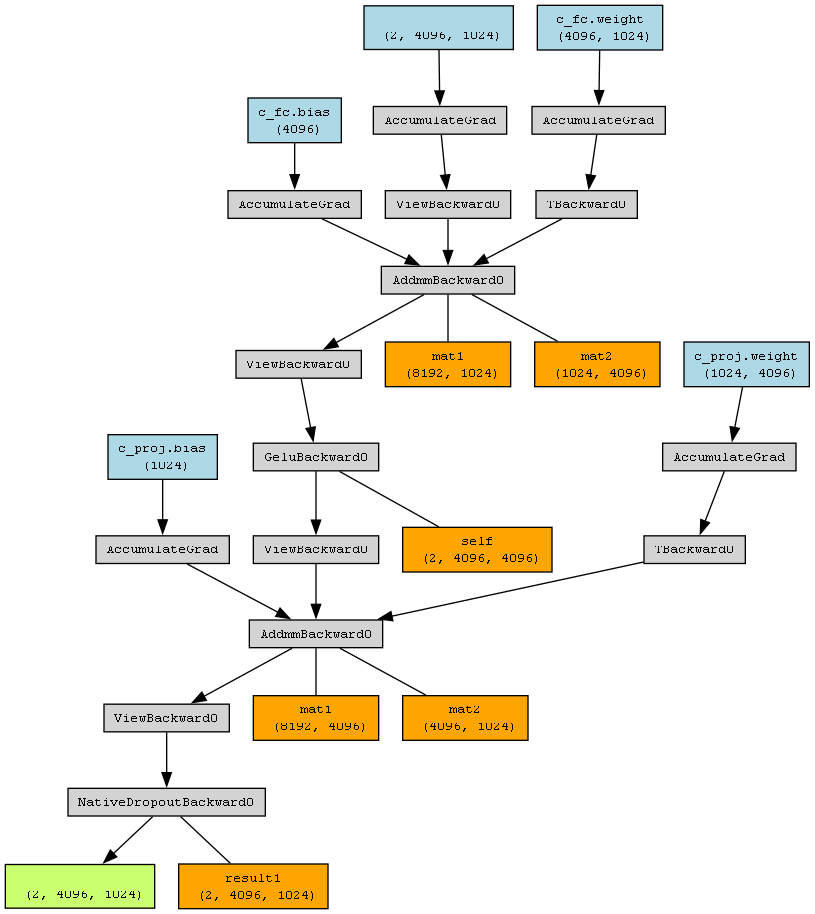

In [4]:
droput_config = GPTConfig(seq_length=seq_len, vocab_size=11, n_embed=d_model, n_head=n_heads, n_layer=7, dropout=0.1, bias=True )
model = MLP(config=droput_config ).to("cuda")
output = summarize(model, input, take_grad=True)

bsf_print(output, model.named_parameters(), print_saved_parameters=False)

dot = torchviz.make_dot(output, params=dict(model.named_parameters()), show_attrs=False, show_saved=True)

from IPython.display import Image

dot.format = 'png'
dot.render('mlp_fp', view=False)
Image(filename='mlp_fp.png')

### MLP - HALF PRECISION + NO BIAS

Now use mixed precision training. Also disable bias. Note CopyBackward functions.

Total params:
8388608
Delta:
{'allocated': 209715200, 'current': 192937984, 'freed': 16777216, 'peak': 209715200}

Computation graph nodes:
- NativeDropoutBackward0
[      result1] - dtype: bool     - Shape: [2, 4096, 1024]    - Addr:   30792482816 - NBytes:    8,388,608 - Size:    8,388,608

- UnsafeViewBackward0
- MmBackward0
[         mat2] - dtype: float16  - Shape: [4096, 1024]       - Addr:   30131879936 - NBytes:    8,388,608 - Size:    8,388,608
[         self] - dtype: float16  - Shape: [8192, 4096]       - Addr:   30708596736 - NBytes:   67,108,864 - Size:   67,108,864

- ViewBackward0
- TBackward0
- GeluBackward0
[         self] - dtype: float16  - Shape: [2, 4096, 4096]    - Addr:   30641487872 - NBytes:   67,108,864 - Size:   67,108,864

- ToCopyBackward0
- UnsafeViewBackward0
* AccumulateGrad - c_proj.weight - [1024, 4096] - dtype: torch.float32 - Addr:   30106714112
- MmBackward0
[         mat2] - dtype: float16  - Shape: [1024, 4096]       - Addr:   30123491328 - NBytes

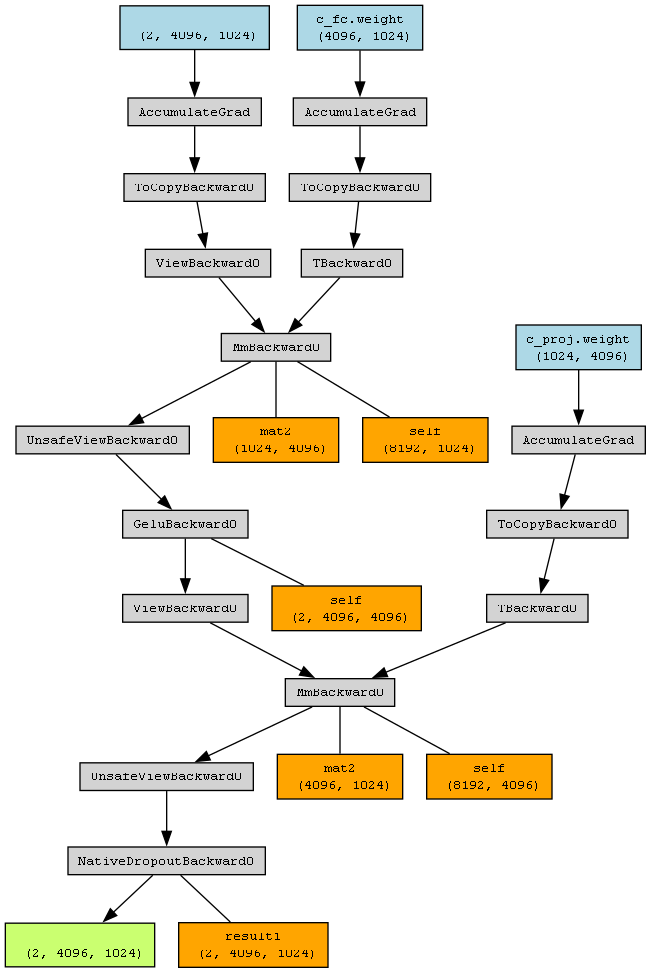

In [5]:
droput_config = GPTConfig(seq_length=seq_len, vocab_size=11, n_embed=d_model, n_head=n_heads, n_layer=7, dropout=0.1,bias=False )
model = MLP(config=droput_config ).to("cuda")
output = summarize(model, input, take_grad=True, dtype=torch.float16)

bsf_print(output, model.named_parameters(), print_saved_parameters=False)

dot = torchviz.make_dot(output, params=dict(model.named_parameters()), show_attrs=False, show_saved=True)

from IPython.display import Image

dot.format = 'png'
dot.render('mlp_mp', view=False)
Image(filename='mlp_mp.png')

## Attention without scaled_dot_product_attention (Manual)

This is the slow attention implemenation. 

Total params:
4194304
Delta:
{'allocated': 1769996288, 'current': 796917760, 'freed': 973078528, 'peak': 654290944}

Computation graph nodes:
- NativeDropoutBackward0
[      result1] - dtype: bool     - Shape: [2, 4096, 1024]    - Addr:   30241062912 - NBytes:    8,388,608 - Size:    8,388,608

- UnsafeViewBackward0
- MmBackward0
[         mat2] - dtype: float32  - Shape: [1024, 1024]       - Addr:   30140268544 - NBytes:    4,194,304 - Size:    4,194,304
[         self] - dtype: float32  - Shape: [8192, 1024]       - Addr:   31434211328 - NBytes:   33,554,432 - Size:   33,554,432

- ViewBackward0
- TBackward0
- ViewBackward0
* AccumulateGrad - c_proj.weight - [1024, 1024] - dtype: torch.float32 - Addr:   30140268544
- CloneBackward0
- TransposeBackward0
- UnsafeViewBackward0
- BmmBackward0
[         mat2] - dtype: float32  - Shape: [4, 4096, 512]     - Addr:   31367102464 - NBytes:   33,554,432 - Size:   33,554,432
[         self] - dtype: float32  - Shape: [4, 4096, 4096]    - Addr: 

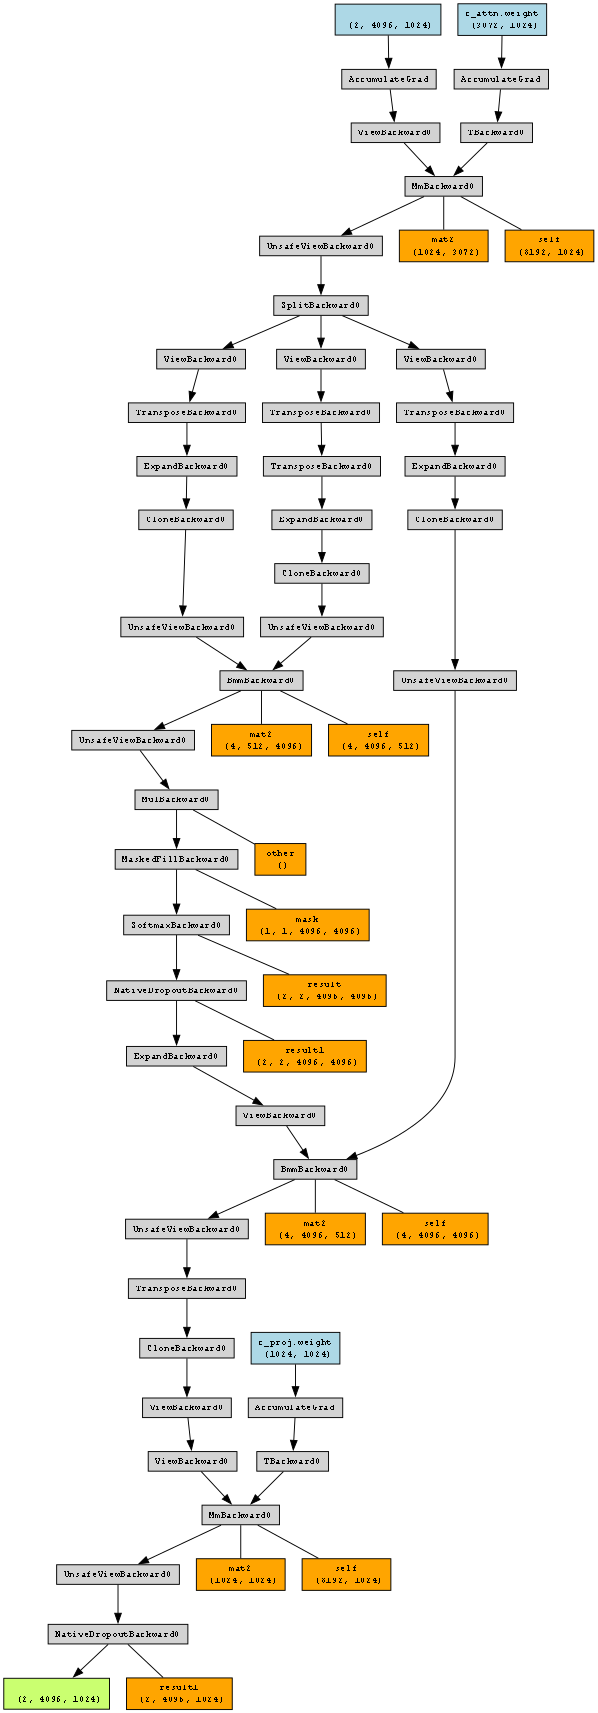

In [6]:
config_dropout = GPTConfig(seq_length=seq_len, vocab_size=11, n_embed=d_model, n_head=n_heads, n_layer=7, dropout=0.1 )
model = CausalSelfAttention(config=config_dropout,allow_flash=False ).to("cuda")
output = summarize(model, input, take_grad=True)

bsf_print(output, model.named_parameters(), print_saved_parameters=False)

dot = torchviz.make_dot(output, params=dict(model.named_parameters()), show_saved=True)

from IPython.display import Image
dot.format = 'png'
dot.render('manual', view=False)
Image(filename='manual.png')

## Efficient Attention with scaled_dot_product_attention

This is efficient attention implementation. It may be flash attention or xformer, depending on the card used.

Total params:
4194304
Delta:
{'allocated': 167837696, 'current': 167837696, 'freed': 0, 'peak': 0}

Computation graph nodes:
- UnsafeViewBackward0
- MmBackward0
[         mat2] - dtype: float32  - Shape: [1024, 1024]       - Addr:   30247354368 - NBytes:    4,194,304 - Size:    4,194,304
[         self] - dtype: float32  - Shape: [8192, 1024]       - Addr:   30354178048 - NBytes:   33,554,432 - Size:   33,554,432

- ViewBackward0
- TBackward0
- ViewBackward0
* AccumulateGrad - c_proj.weight - [1024, 1024] - dtype: torch.float32 - Addr:   30247354368
- TransposeBackward0
- ScaledDotProductEfficientAttentionBackward0
[          key] - dtype: float32  - Shape: [2, 2, 4096, 512]  - Addr:   30253514752 - NBytes:  100,663,296 - Size:   33,554,432
[   log_sumexp] - dtype: float32  - Shape: [2, 2, 4096]       - Addr:   30203314176 - NBytes:       65,536 - Size:       65,536
[       output] - dtype: float32  - Shape: [2, 2, 4096, 512]  - Addr:   30354178048 - NBytes:   33,554,432 - Size:   33,5

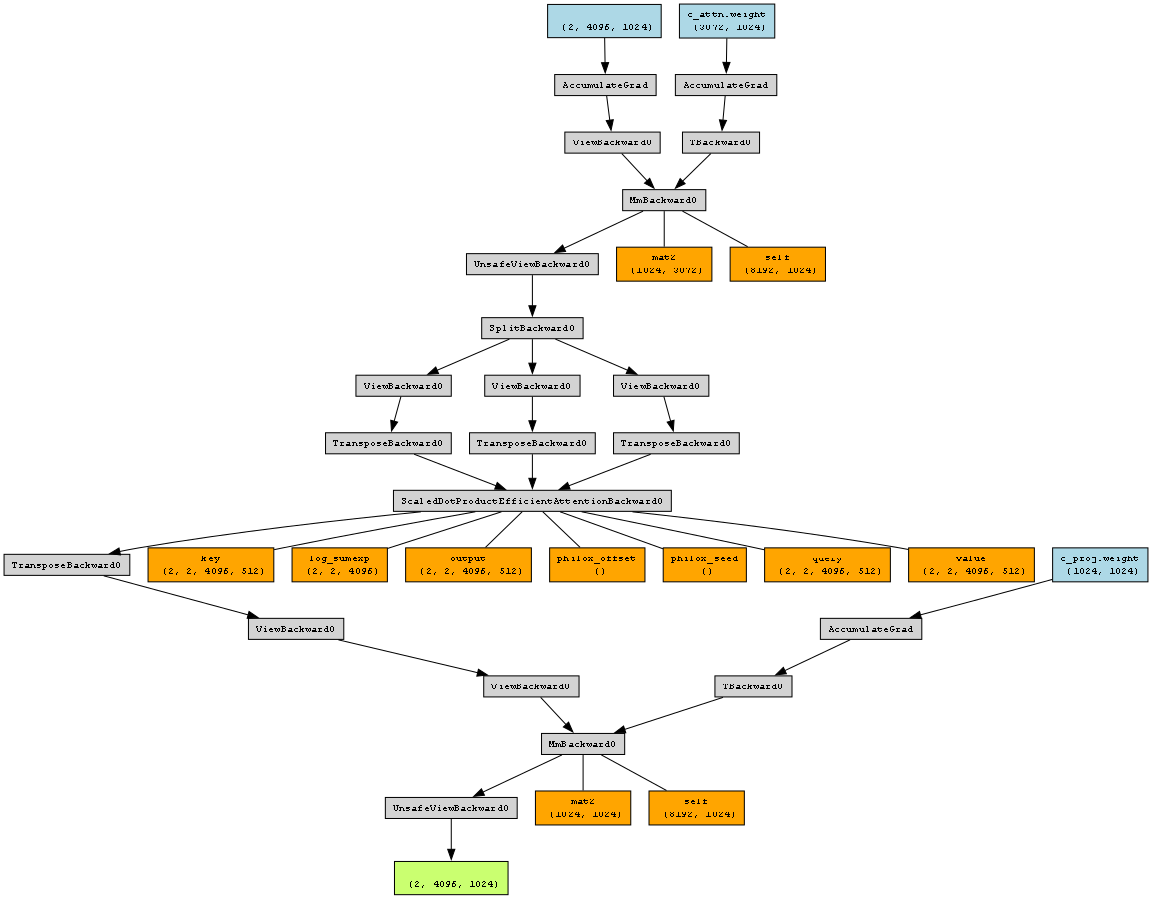

In [10]:
model = CausalSelfAttention(config=config,allow_flash=True ).to("cuda")
output  = summarize(model, input, take_grad=True)

bsf_print(output, model.named_parameters(), print_saved_parameters=False)

dot = torchviz.make_dot(output, params=dict(model.named_parameters()), show_saved=True)

from IPython.display import Image
dot.format = 'png'
dot.render('attention_fp', view=False)
Image(filename='attention_fp.png')

### Mixed precision + dropout

Total params:
4194304
Delta:
{'allocated': 167837696, 'current': 117506048, 'freed': 50331648, 'peak': 0}

Computation graph nodes:
- NativeDropoutBackward0
[      result1] - dtype: bool     - Shape: [2, 4096, 1024]    - Addr:   30775705600 - NBytes:    8,388,608 - Size:    8,388,608

- UnsafeViewBackward0
- MmBackward0
[         mat2] - dtype: float16  - Shape: [1024, 1024]       - Addr:   30805065728 - NBytes:    2,097,152 - Size:    2,097,152
[         self] - dtype: float16  - Shape: [8192, 1024]       - Addr:   30624710656 - NBytes:   16,777,216 - Size:   16,777,216

- ViewBackward0
- TBackward0
- ViewBackward0
- ToCopyBackward0
- TransposeBackward0
* AccumulateGrad - c_proj.weight - [1024, 1024] - dtype: torch.float32 - Addr:   30198988800
- ScaledDotProductEfficientAttentionBackward0
[          key] - dtype: float16  - Shape: [2, 2, 4096, 512]  - Addr:   30641487872 - NBytes:   50,331,648 - Size:   16,777,216
[   log_sumexp] - dtype: float32  - Shape: [2, 2, 4096]       - Addr: 

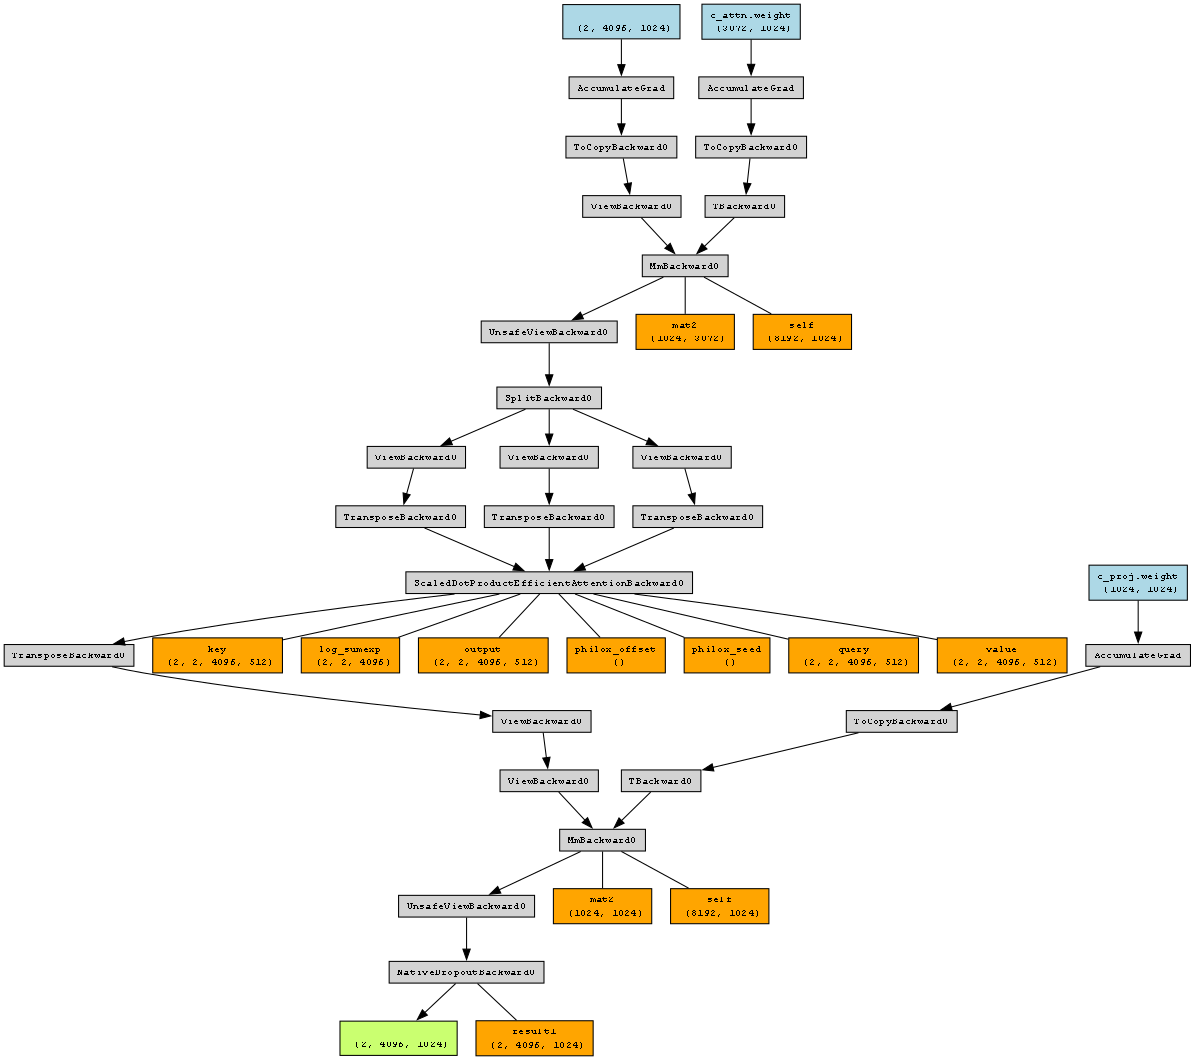

In [11]:
config_dropout = GPTConfig(seq_length=seq_len, vocab_size=11, n_embed=d_model, n_head=n_heads, n_layer=7, dropout=0.1 )
model = CausalSelfAttention(config=config_dropout,allow_flash=True ).to("cuda")
output = summarize(model, input, take_grad=True, dtype=torch.float16)

bsf_print(output, model.named_parameters(), print_saved_parameters=False)

dot = torchviz.make_dot(output, params=dict(model.named_parameters()), show_saved=True)

from IPython.display import Image

dot.format = 'png'
dot.render('attention_mp', view=False)
Image(filename='attention_mp.png')

## Block with scaled_dot_product_attention

Now check a complete transformer block

Total params:
12584960
Delta:
{'allocated': 604176384, 'current': 537067520, 'freed': 67108864, 'peak': 0}

Computation graph nodes:
- AddBackward0
- AddBackward0
- UnsafeViewBackward0
* AccumulateGrad - 'Name not known' - [2, 4096, 1024] - dtype: torch.float32 - Addr:   30150754304
- UnsafeViewBackward0
- MmBackward0
[         mat2] - dtype: float32  - Shape: [4096, 1024]       - Addr:   30123491328 - NBytes:   16,777,216 - Size:   16,777,216
[         self] - dtype: float32  - Shape: [8192, 4096]       - Addr:   30830231552 - NBytes:  134,217,728 - Size:  134,217,728

- MmBackward0
[         mat2] - dtype: float32  - Shape: [1024, 1024]       - Addr:   30247354368 - NBytes:    4,194,304 - Size:    4,194,304
[         self] - dtype: float32  - Shape: [8192, 1024]       - Addr:   30354178048 - NBytes:   33,554,432 - Size:   33,554,432

- ViewBackward0
- TBackward0
- ViewBackward0
- TBackward0
- GeluBackward0
[         self] - dtype: float32  - Shape: [2, 4096, 4096]    - Addr:   304569

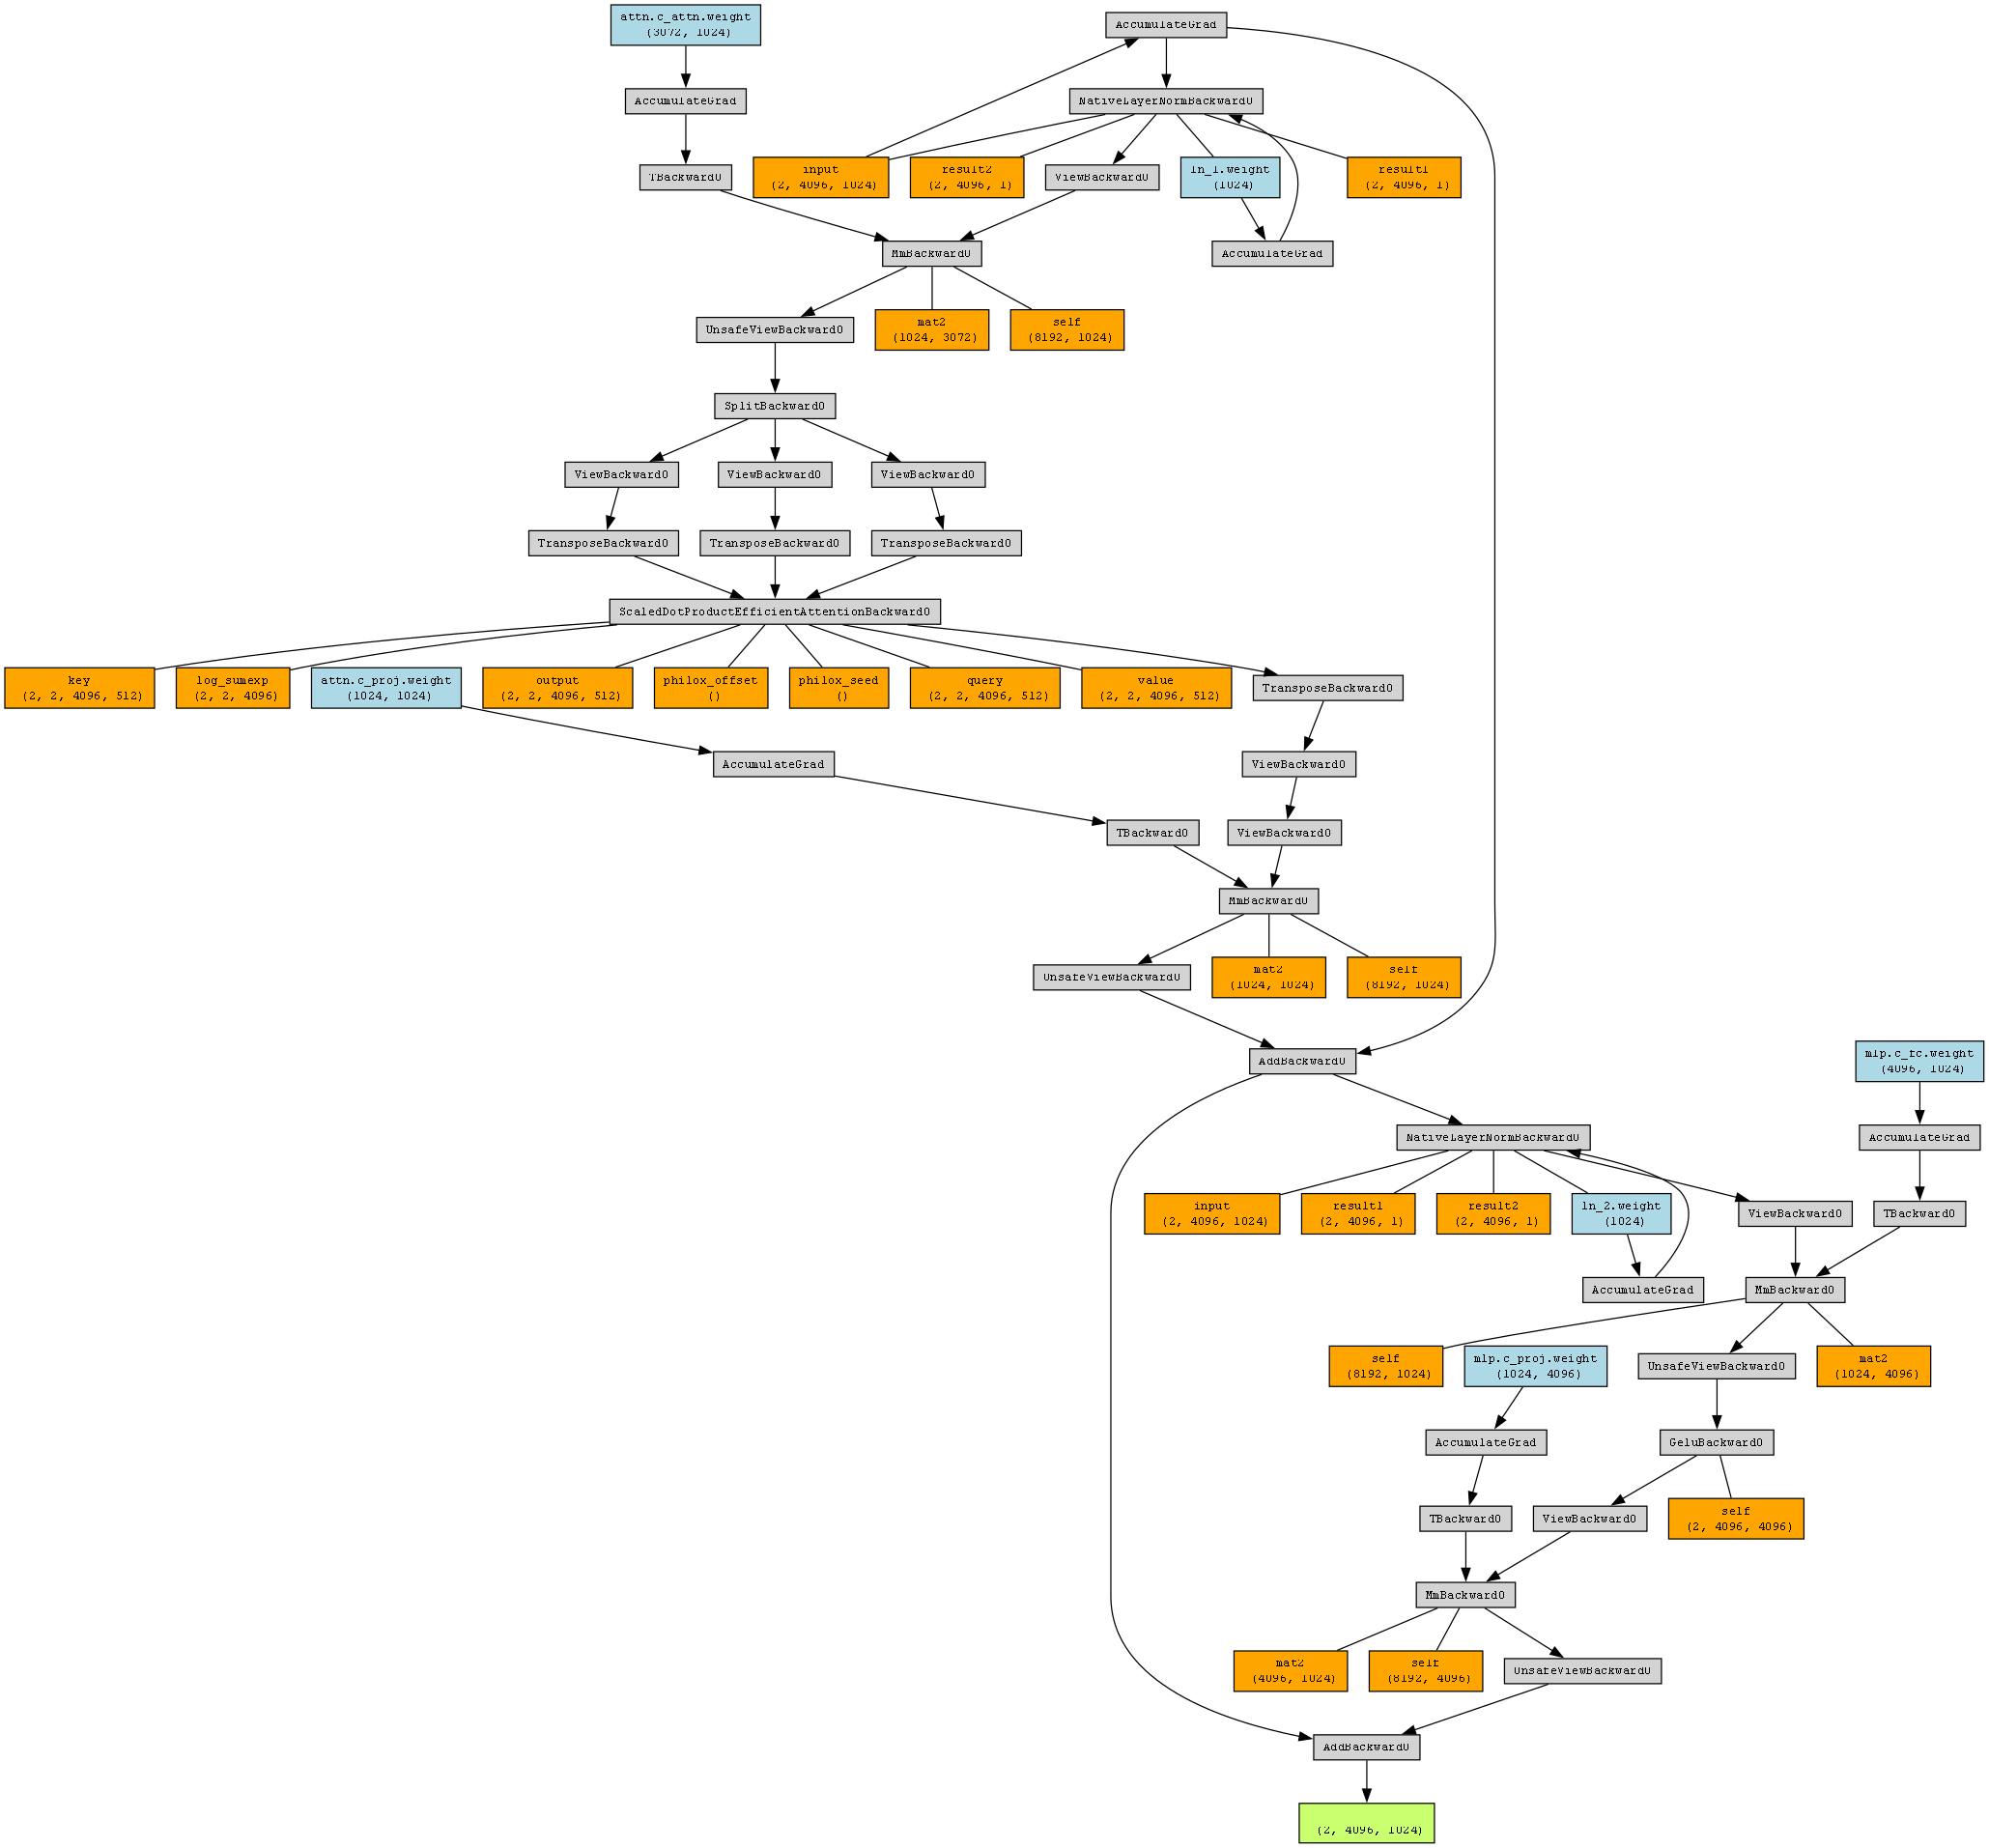

In [12]:
config_dropout = GPTConfig(seq_length=seq_len, vocab_size=11, n_embed=d_model, n_head=n_heads, n_layer=7, dropout=0, bias=False )
model = Block(config=config_dropout).to("cuda")
output = summarize(model, input, take_grad=True, dtype=torch.float32)

bsf_print(output, model.named_parameters(), print_saved_parameters=False)

dot = torchviz.make_dot(output, params=dict(model.named_parameters()), show_saved=True)

from IPython.display import Image

dot.format = 'png'
dot.render('attention_block_fp', view=False)
Image(filename='attention_block_fp.png')

## GPT 

Now check a gpt model with one transfomer layer.

number of parameters: 12.60M


c:\Users\habanoz\Desktop\gpt\gpt2_torch_activation_tests\gpt2.py:78: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)


Total params:
16796672
Delta:
{'allocated': 722239488, 'current': 604798976, 'freed': 117440512, 'peak': 655130624}

Computation graph nodes:
- UnsafeViewBackward0
- MmBackward0
[         mat2] - dtype: float32  - Shape: [1024, 16]         - Addr:   30186471424 - NBytes:       65,536 - Size:       65,536
[         self] - dtype: float32  - Shape: [8192, 1024]       - Addr:   30893146112 - NBytes:   33,554,432 - Size:   33,554,432

- ViewBackward0
- TBackward0
- NativeLayerNormBackward0
[        input] - dtype: float32  - Shape: [2, 4096, 1024]    - Addr:   30926700544 - NBytes:   33,554,432 - Size:   33,554,432
[      result1] - dtype: float32  - Shape: [2, 4096, 1]       - Addr:   30186778624 - NBytes:       32,768 - Size:       32,768
[      result2] - dtype: float32  - Shape: [2, 4096, 1]       - Addr:   30186811392 - NBytes:       32,768 - Size:       32,768
[       weight] - dtype: torch.float32 - Shape: [1024]          Tensor: transformer.ln_f.weight

* AccumulateGrad - transform

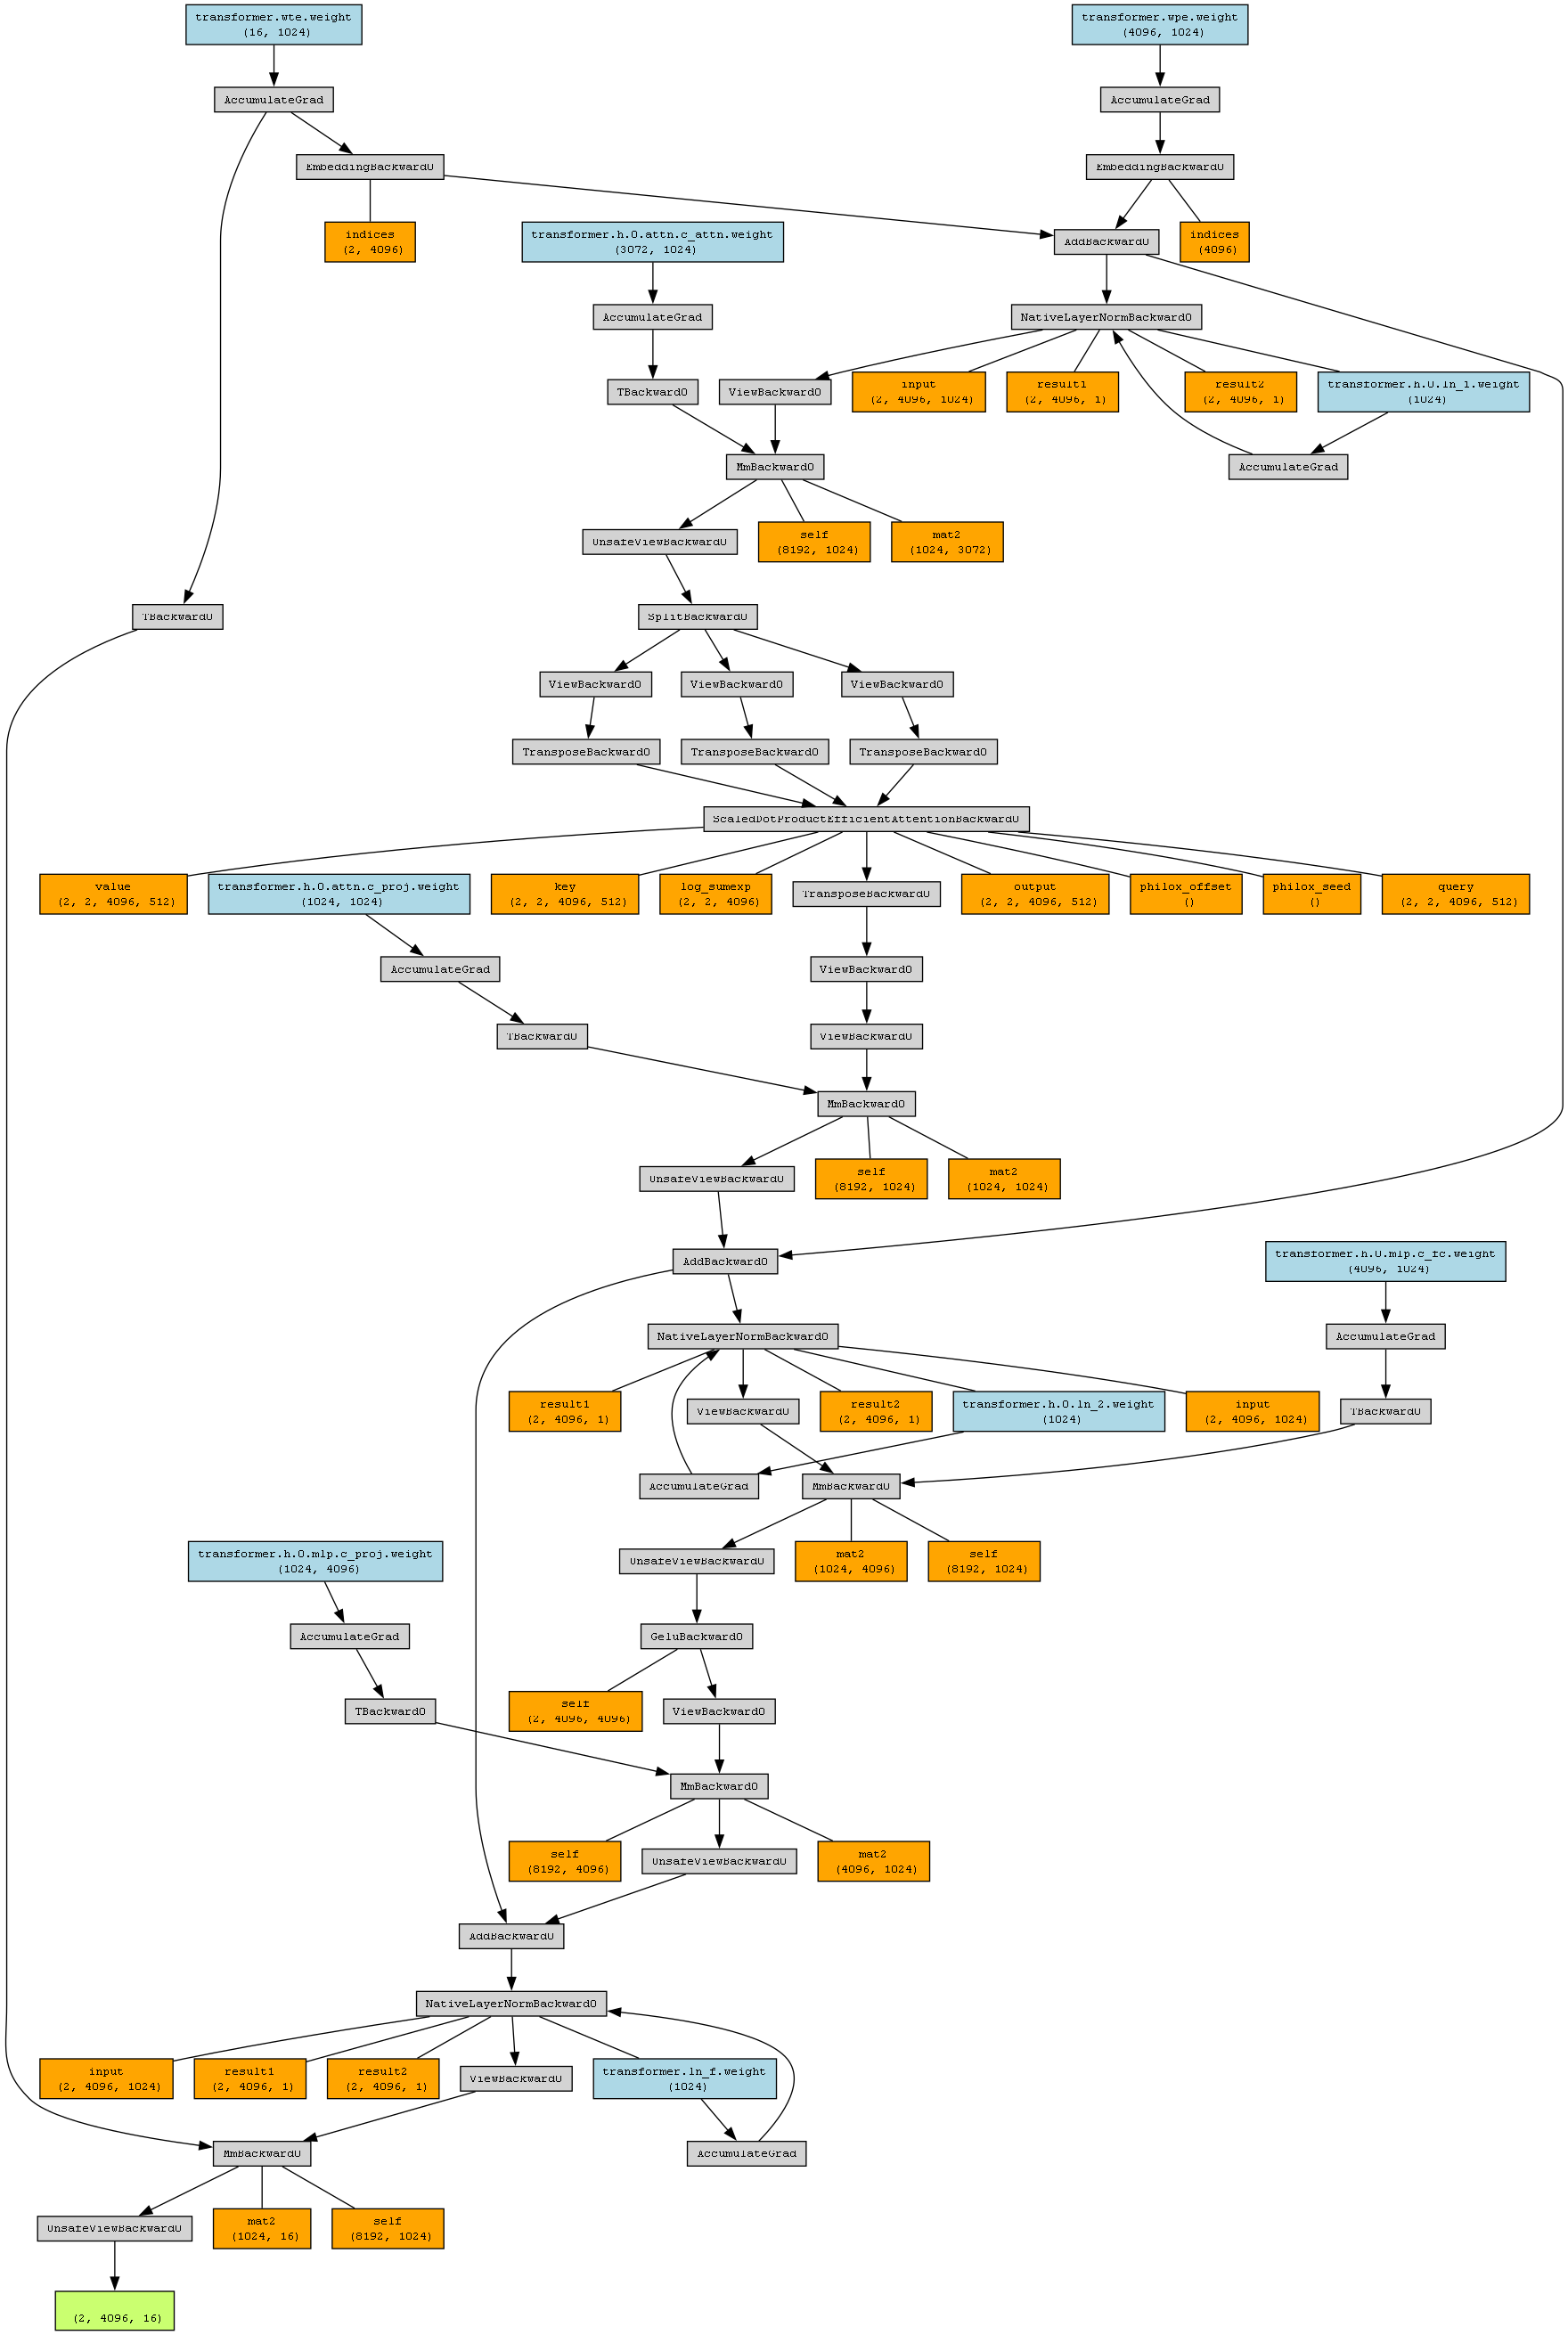

In [5]:
gpt_input = torch.randint(0, 16, (batch_size, seq_len)).to("cuda")
config_dropout = GPTConfig(seq_length=seq_len, vocab_size=16, n_embed=d_model, n_head=n_heads, n_layer=1, dropout=0,bias=False )
model = GPT(config=config_dropout).to("cuda")
output = summarize(model, gpt_input, take_grad=True, dtype=torch.float32)

bsf_print(output, model.named_parameters(), print_saved_parameters=False)

dot = torchviz.make_dot(output, params=dict(model.named_parameters()), show_saved=True, show_attrs=False)

from IPython.display import Image

dot.format = 'png'
dot.render('gpt_2', view=False)
Image(filename='gpt_2.png')